In [1]:
import pandas as pd

import torch
from torch.utils.data import DataLoader

from himodule.normalisation import MinMaxScaler, StandardScaler
from himodule.secondary_funcs import load_object, save_object, check_path
from himodule.custom_classes import NasaDataset, AnomalyDataset, AnomalyLoader, split_anomaly_normal, seed_everything, SimpleAE

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


In [3]:
SEED = 37

In [6]:
train_dataset = NasaDataset('../datasets/clean_train_data.csv')
train_dataset, anomaly_dataset = split_anomaly_normal(train_dataset)

scaler_path = '../scalers/MinMaxScaler.pkl'
scaler = load_object('../scalers/MinMaxScaler.pkl')
try:
    norm_name = repr(scaler).split(' ', maxsplit=2)[0].split('.')[-1]
except IndexError:
    norm_name = 'no_scaling'
for idx, dtset in enumerate((train_dataset, anomaly_dataset)):
    dtset.to(device)
    if scaler:
        if idx == 0:
            scaler.fit(dtset.dataset)
        dtset.dataset = scaler.transform(dtset.dataset)

seed_everything(SEED)
g = torch.Generator()
g.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=SEED, generator=g)
seed_everything(SEED)

seed_everything(SEED)
anomaly_loader = AnomalyLoader(anomaly_dataset, batch_size=20)

print(f'Train: {len(train_dataset)}')
print(f'Anomaly: {len(anomaly_dataset)}')

Train: 8131
Anomaly: 12500


In [7]:
models_path = '../Models/norm-anom/'
layers_sizes = (8, 4, 2)

model_ae = SimpleAE(train_dataset.get_input_shape(), layers_sizes=layers_sizes)
model_ae.load_state_dict(torch.load(os.path.join(models_path, f'{layers_sizes}.pth')))
model_ae.to(device)

SimpleAE(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): SiLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): SiLU()
    (4): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): SiLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): SiLU()
    (4): Linear(in_features=2, out_features=16, bias=True)
  )
)

In [14]:
def get_visualisation_data(model: SimpleAE, train_dataset: NasaDataset, anomaly_dataset: AnomalyDataset, n_cycles: int):
    g = torch.Generator()
    g.manual_seed(SEED)
    seed_everything(SEED)
    normal_data = train_dataset[torch.randperm(len(train_dataset), generator=g)[:n_cycles]]['sensors']
    seed_everything(SEED)
    anomaly_data = anomaly_dataset[torch.randperm(len(anomaly_dataset), generator=g)[:n_cycles]]['sensors']

    with torch.no_grad():
        _, normal_reconstruction = model(normal_data)
        _, anomaly_reconstruction = model(anomaly_data)
        normal_reconstruction = scaler.inverse_transform(normal_reconstruction)
        anomaly_reconstruction = scaler.inverse_transform(anomaly_reconstruction)

    columns = [i+1 for i in range(normal_reconstruction.shape[1])]
    normal_df = pd.DataFrame(normal_reconstruction.cpu(), columns=columns).melt()
    normal_df['type'] = 'normal'
    anomaly_df = pd.DataFrame(anomaly_reconstruction.cpu(), columns=columns).melt()
    anomaly_df['type'] = 'anomaly'
    df = pd.concat((normal_df, anomaly_df), axis=0)
    return df


def make_plot(df: pd.DataFrame, n_cycles: int, title: str, save_path: str = None):
    plt.close()
    fig, axes = plt.subplots(4, 4)
    fig.set_size_inches(10, 10)

    for ax, sensor_id in zip(axes.flatten(), df['variable'].unique()):
        
        sns.stripplot(data=df[df['variable'] == sensor_id],
                    x='variable',
                    y='value',
                    hue='type',
                    palette=['g', 'r'],
                    dodge=True,
                    ax=ax,
                    zorder=0)
        
        sns.boxplot(data=df[df['variable'] == sensor_id],
                    x='variable',
                    y='value',
                    hue='type',
                    boxprops={"facecolor": (0, 0, 0, 0)},
                    showfliers=False,
                    ax=ax,
                    zorder=1)

        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.get_legend().remove()

    fig.suptitle(title)

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, f'{n_cycles}.png'))
    plt.show()

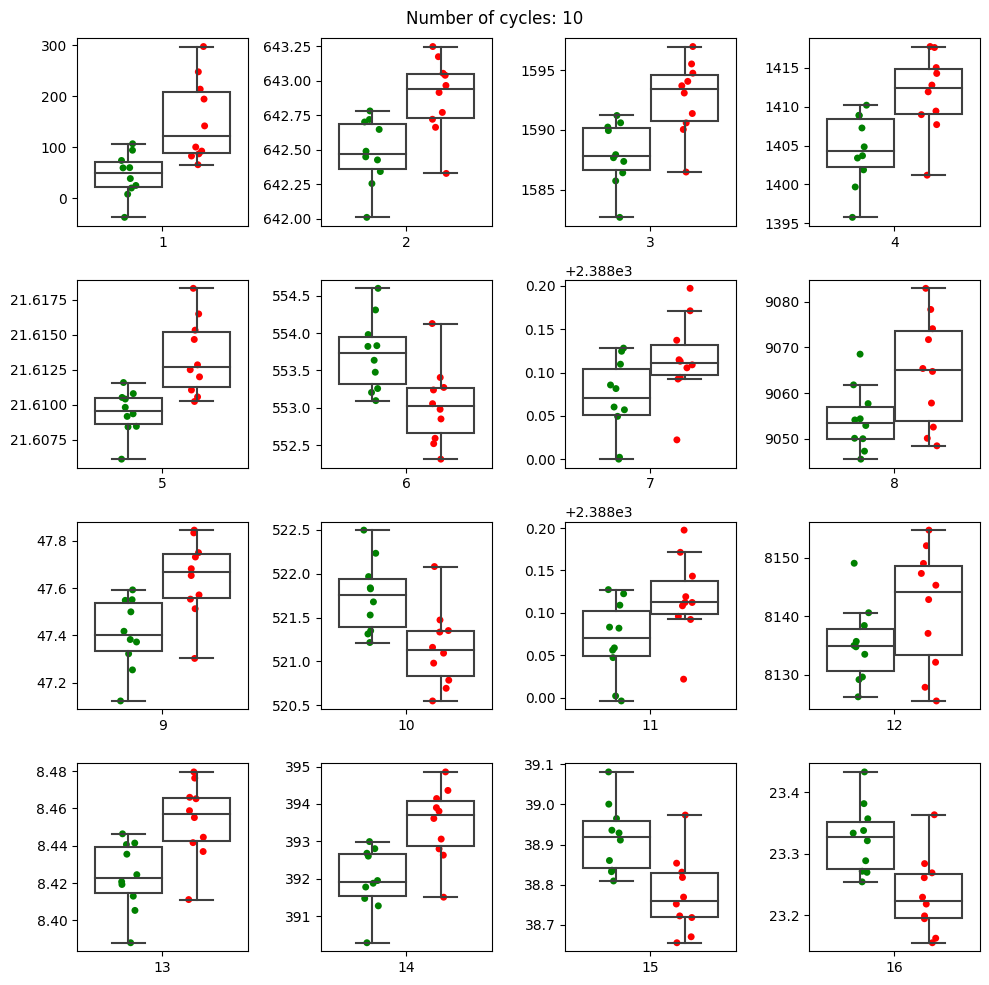

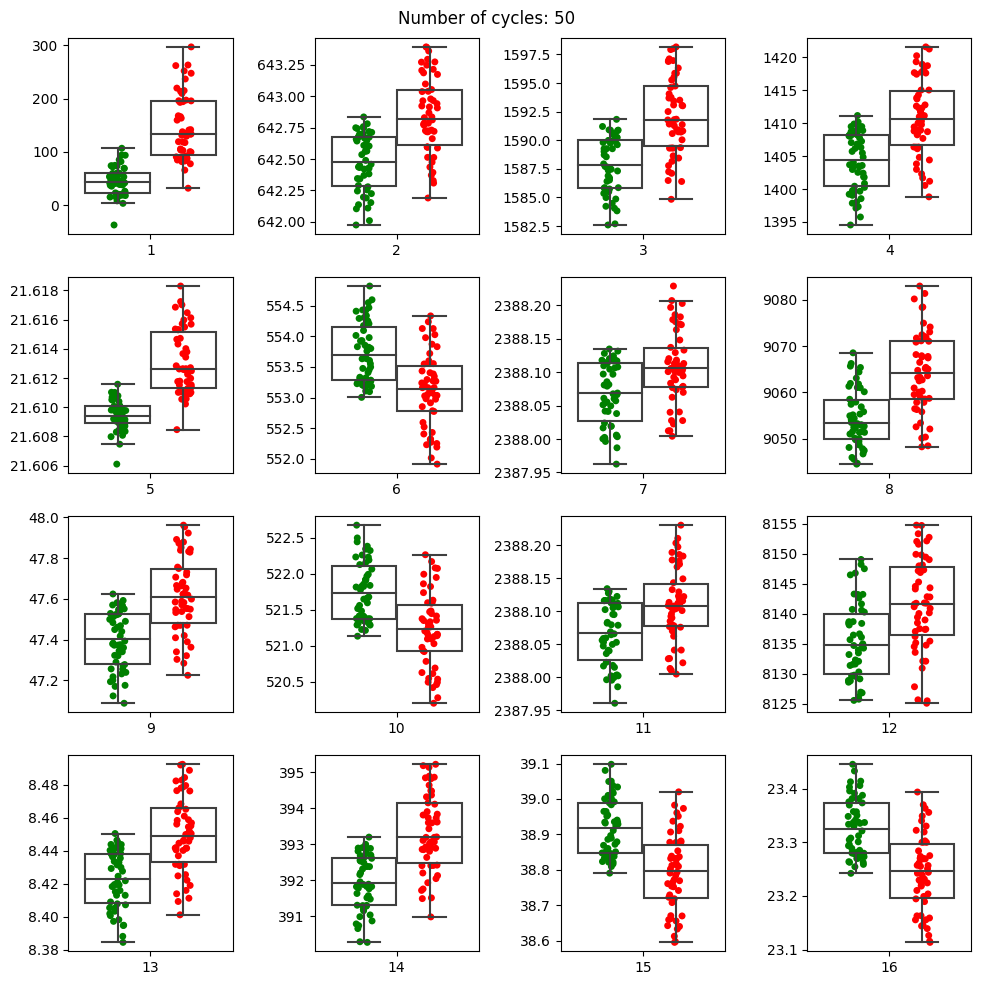

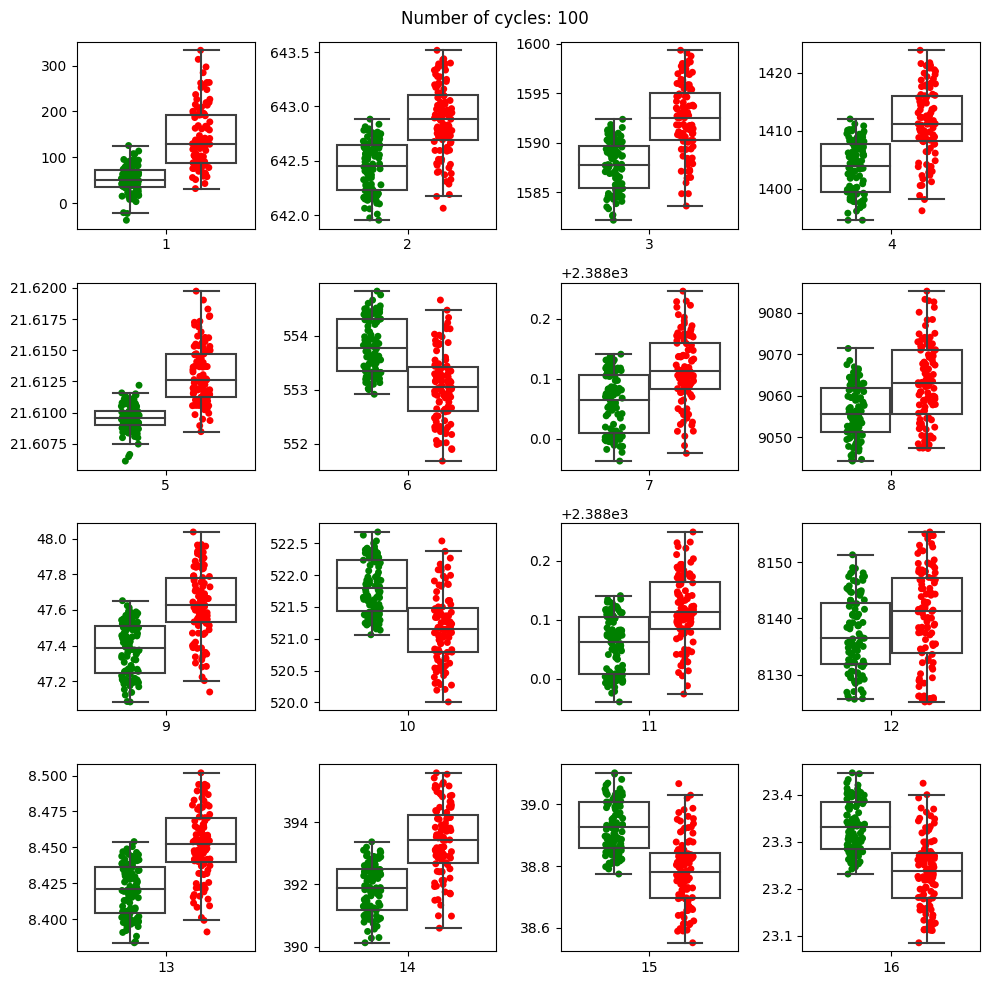

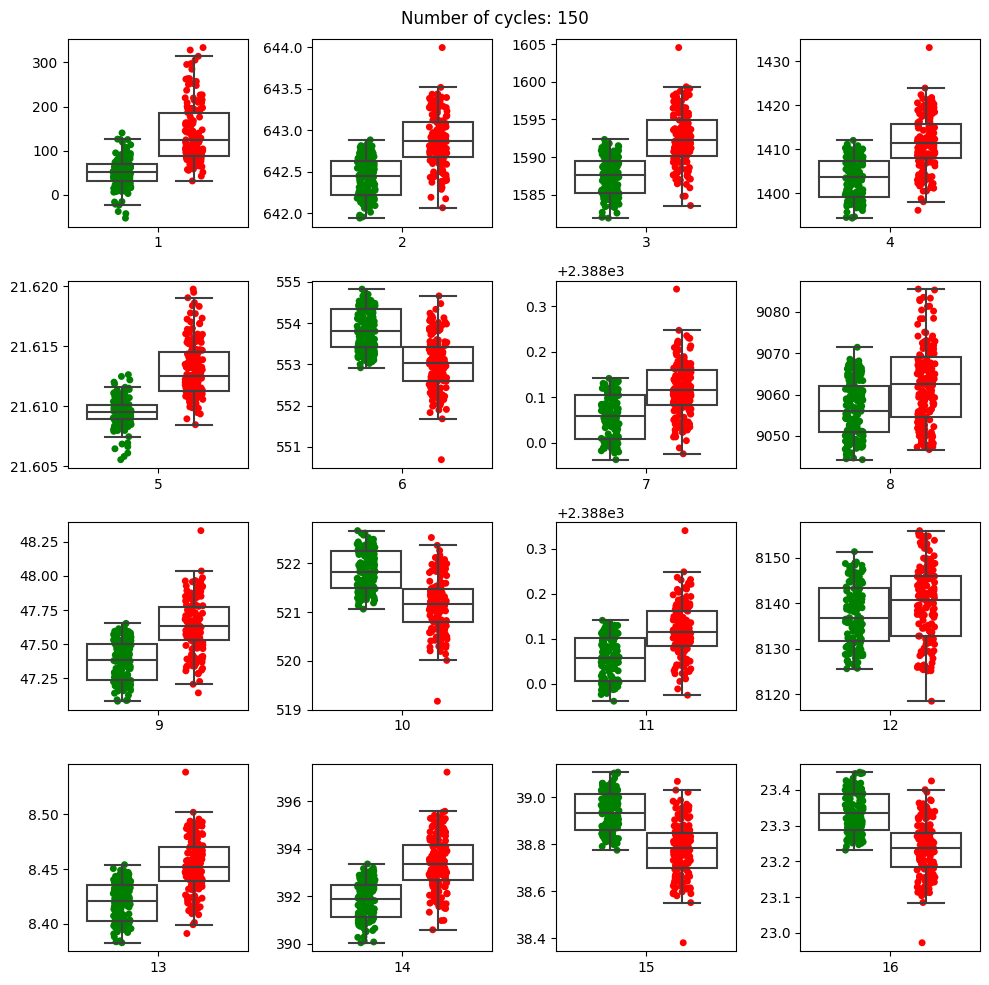

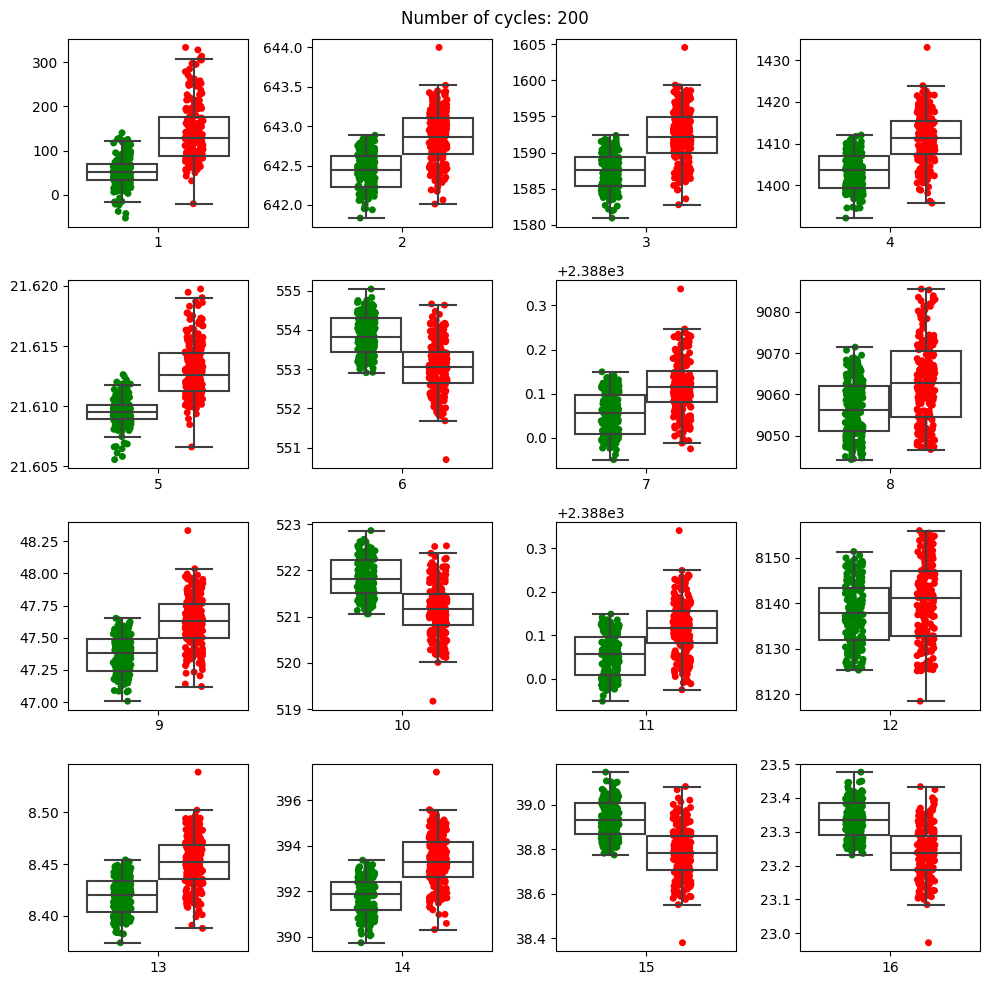

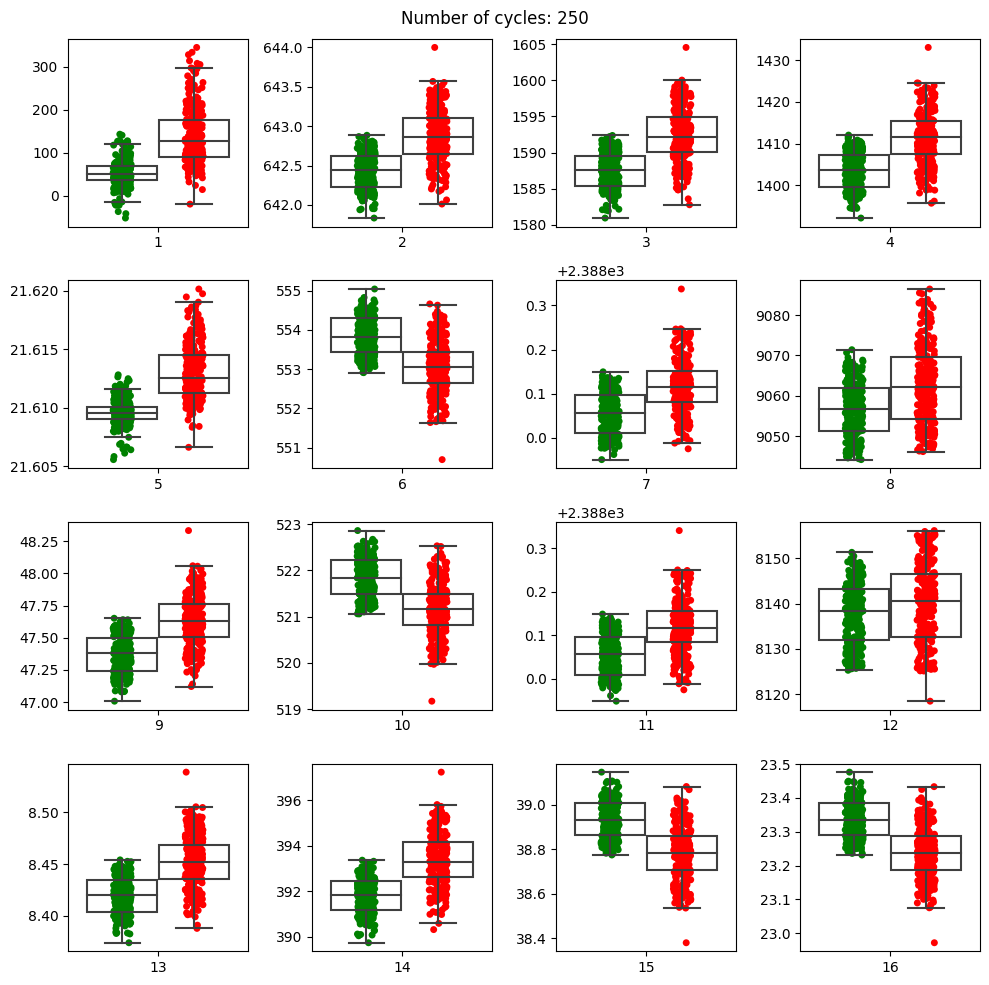

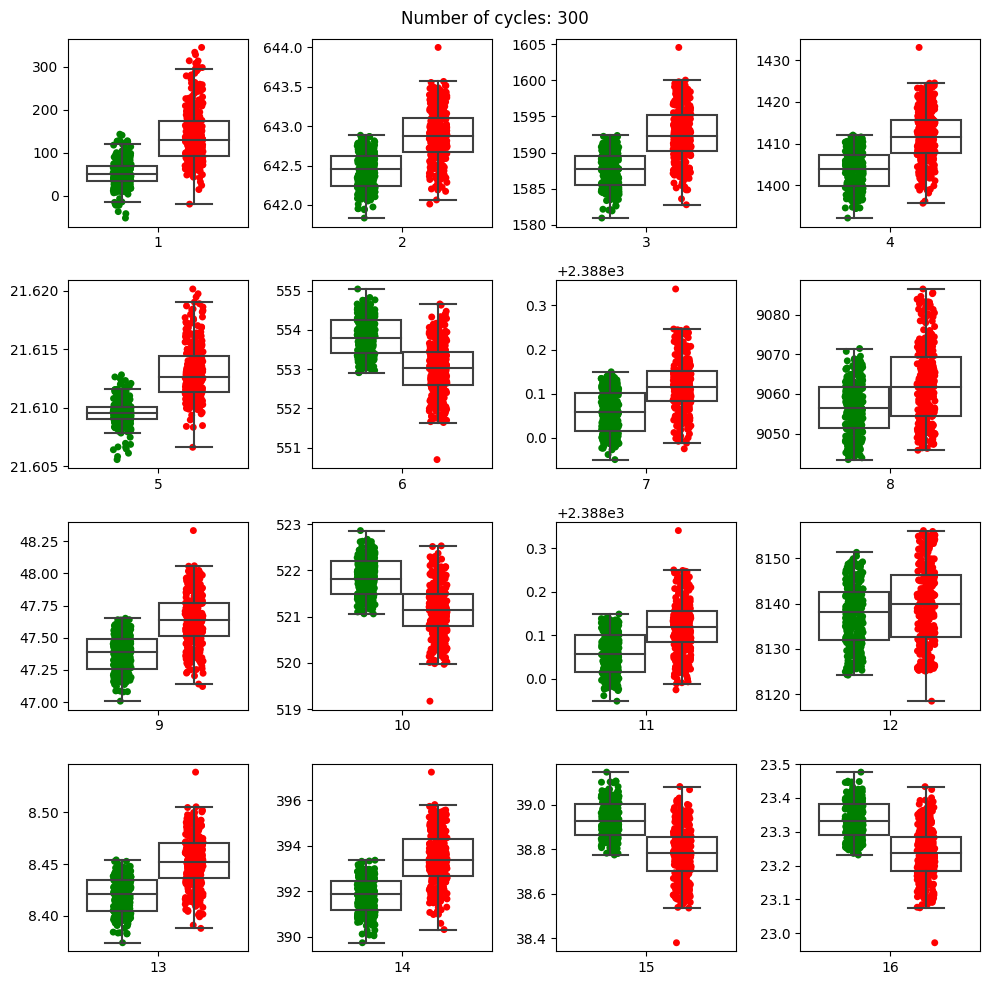

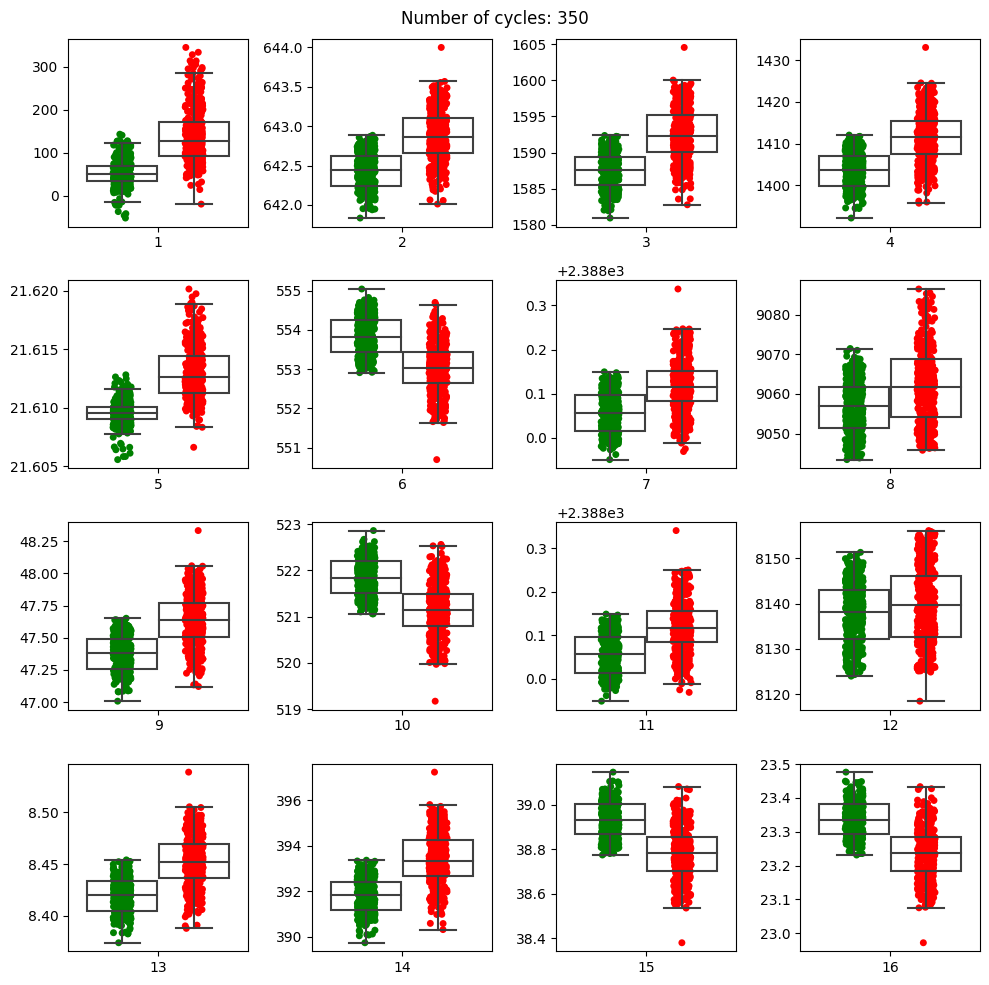

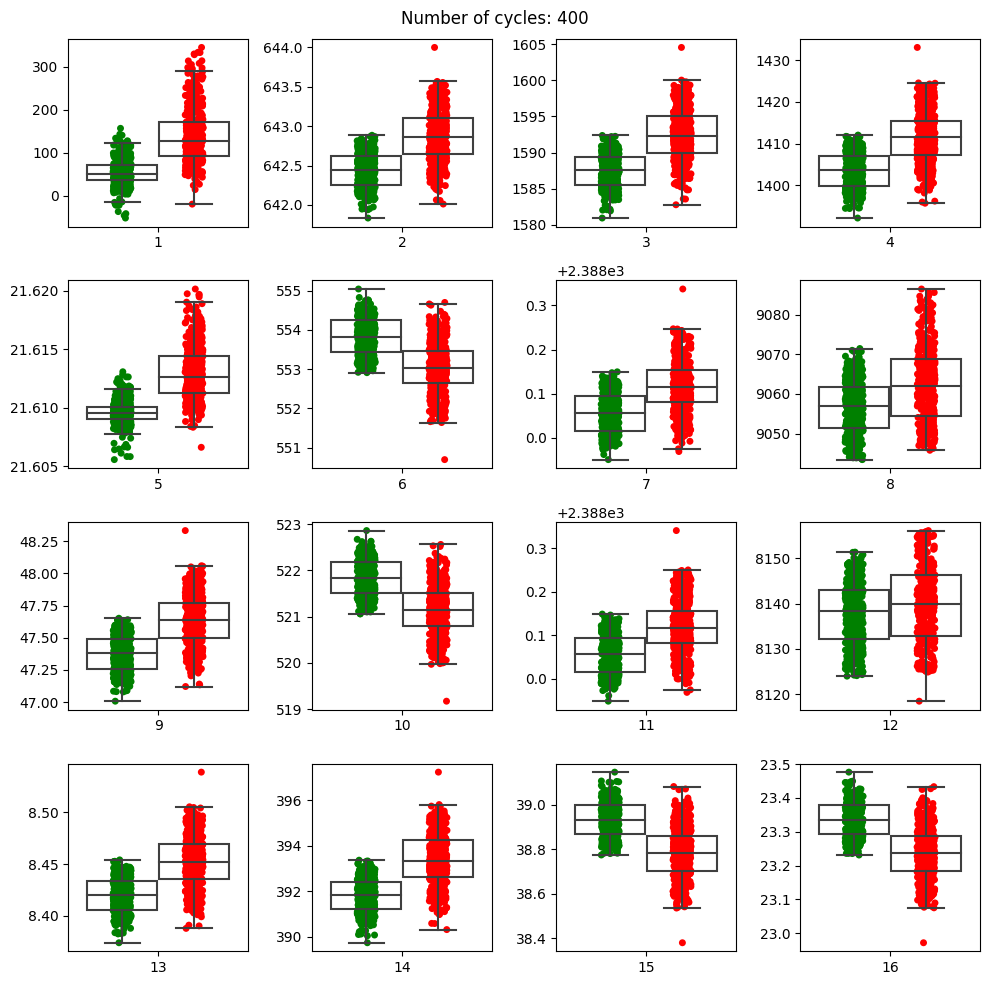

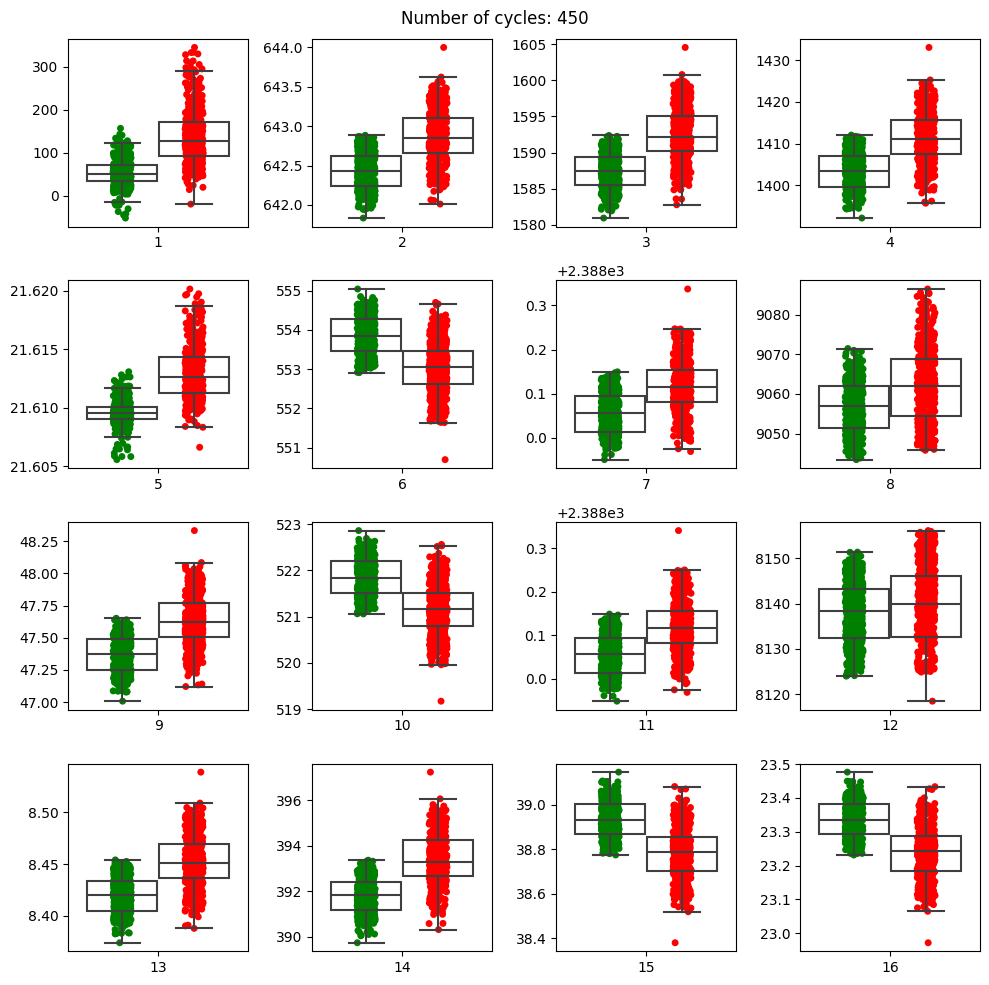

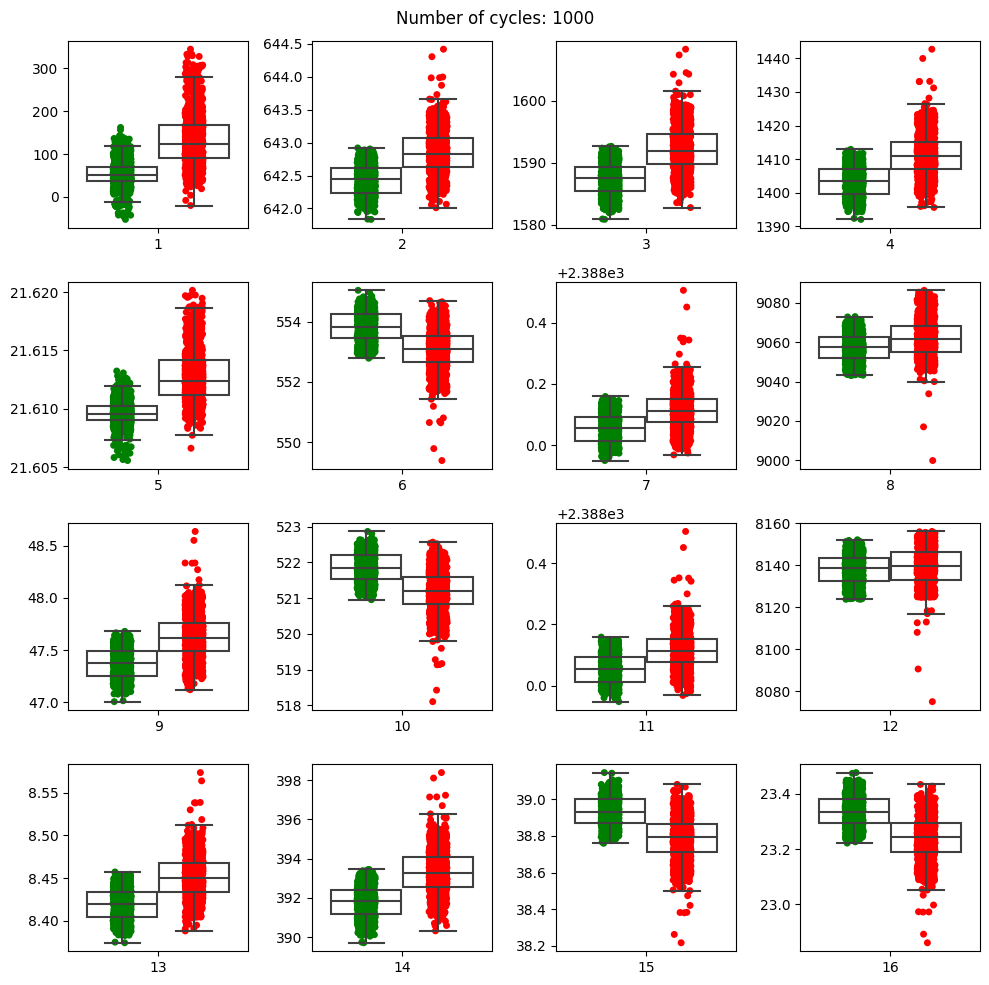

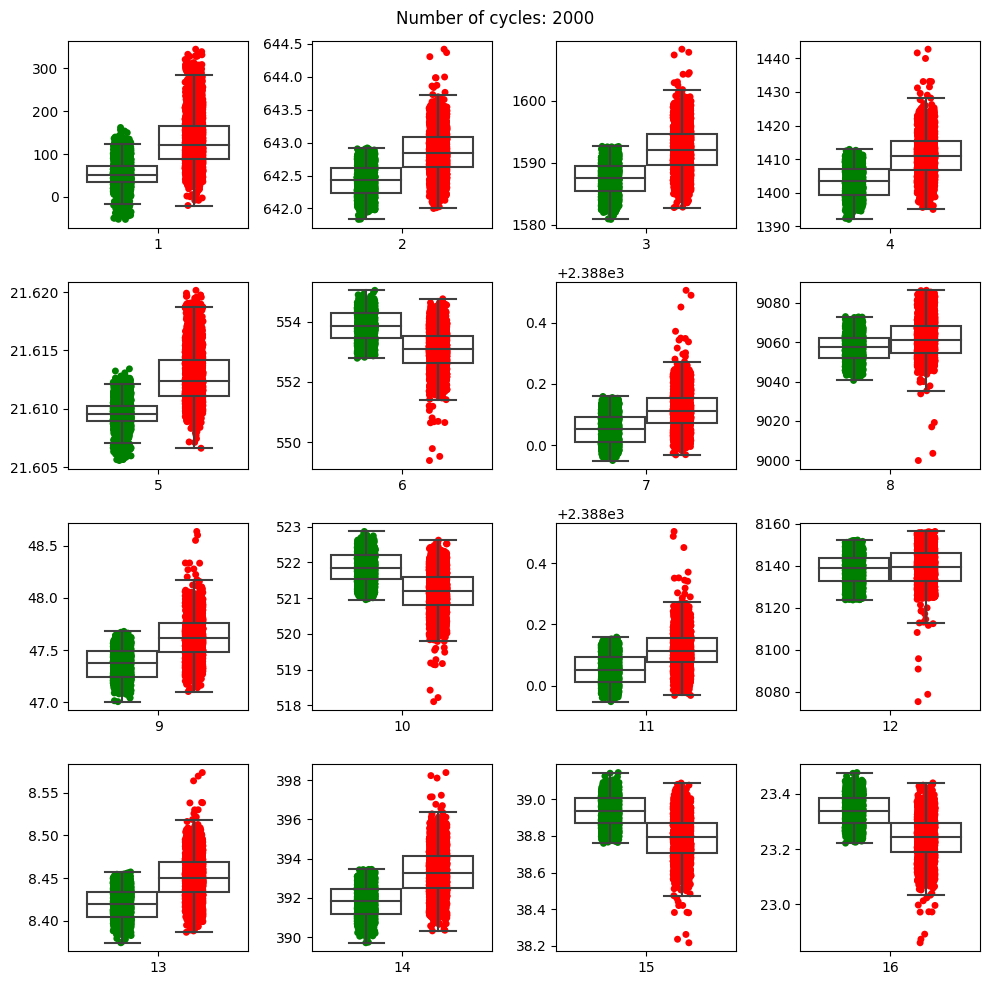

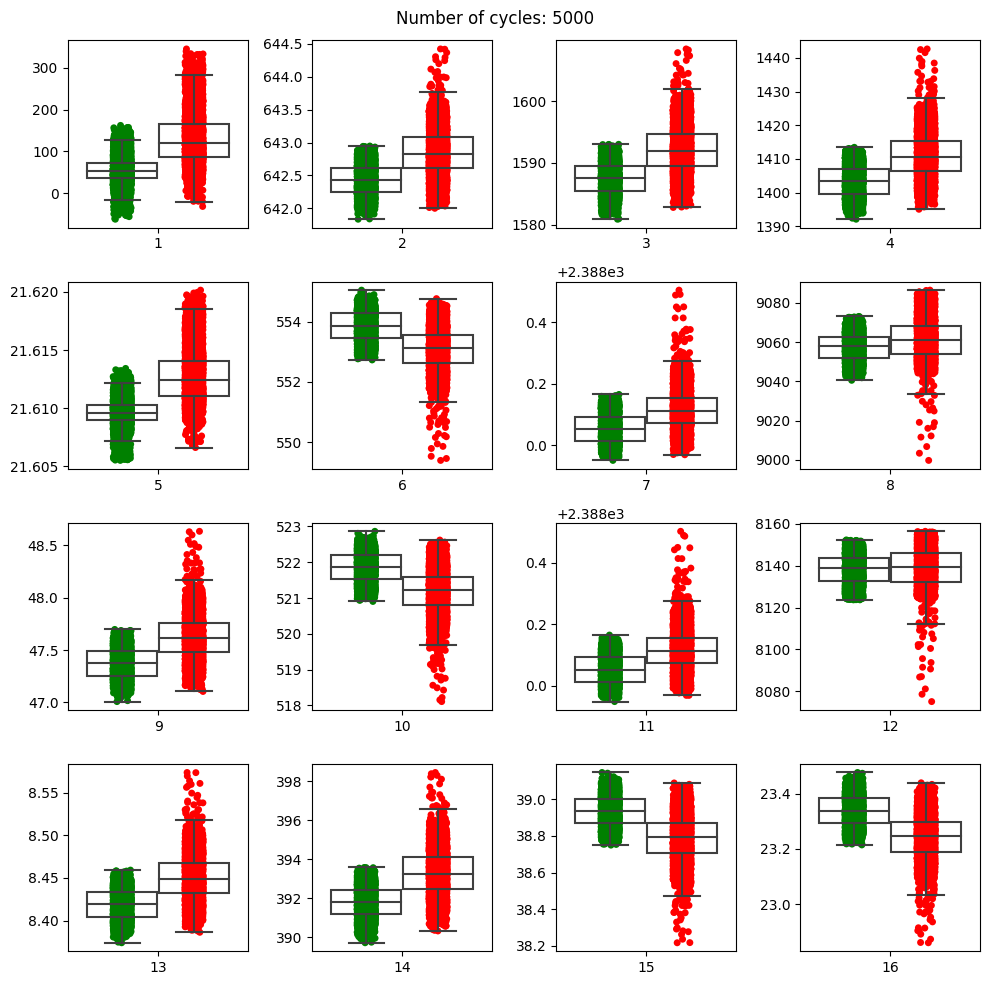

In [15]:
plot_path = '../Plots/reconstruction_visualisation/'
check_path(plot_path)

for n_cycles in (10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 1000, 2000, 5000):
    df = get_visualisation_data(model_ae, train_dataset, anomaly_dataset, n_cycles)
    title = f'Number of cycles: {n_cycles}'
    make_plot(df, n_cycles, title=title, save_path=plot_path)